In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score
import numpy as np

In [7]:
def load_data(path):
    if path.endswith('.csv'):
        df = pd.read_csv(path)
    elif path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(path)
    else:
        raise ValueError("Format de fichier non supporté. Utilisez CSV ou Excel.")
    df.columns = [re.sub(r'[\*]', '', col) for col in df.columns]
    
    # Convertir les colonnes de dates en format datetime
    date_columns = ['end_date']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    
    return df

In [ ]:
data_2003_2023=load_data('data/data_2003_to_2023.csv')
print(data_2003_2023)

          id  duration   end_date  humidity_1day_before_date  \
0     2003_1         1 2003-01-06                        NaN   
1     2003_2         1 2003-01-19                        NaN   
2     2003_3         2 2003-01-27                   5.144191   
3     2003_4         9 2003-02-06                   5.359389   
4     2003_5         2 2003-02-21                   5.611569   
..       ...       ...        ...                        ...   
780  2022_35         2 2023-11-28                   4.784630   
781  2022_36         1 2023-12-01                   4.798316   
782  2022_37         2 2023-12-09                   4.845018   
783  2022_38         2 2023-12-14                   4.797050   
784  2022_39         1 2023-12-20                   4.747163   

     humidity_3days_after_date  humidity_3days_before_date  humidity_end_date  \
0                          NaN                         NaN                NaN   
1                          NaN                         NaN           

In [9]:
def add_month_season(df, colonne_date):
    # Convertir la colonne de dates en format datetime si ce n'est pas déjà fait
    df[colonne_date] = pd.to_datetime(df[colonne_date], errors='coerce')

    # Ajouter une colonne pour le mois
    df['Month'] = df[colonne_date].dt.strftime('%B')

    # Ajouter une colonne pour la saison
    def obtenir_saison(mois):
        if mois in [12, 1, 2]:
            return 'Winter'
        elif mois in [3, 4, 5]:
            return 'Spring'
        elif mois in [6, 7, 8]:
            return 'Summer'
        elif mois in [9, 10, 11]:
            
            return 'Fall'
            
        else:
            return 'Unknown'

    df['Season'] = df[colonne_date].dt.month.apply(obtenir_saison)

    return df

In [10]:
data2003_to_2023_with_tf=add_month_season(data_2003_2023, 'end_date')



In [11]:
def add_derivate_features(df):
    # Calculer la différence entre humidity_end_date et humidity_1day_before_date
    df['humidity_diff_end_1day'] = df['humidity_end_date'] - df['humidity_1day_before_date']

    # Calculer le taux de changement
    df['humidity_rate_of_change'] = (df['humidity_end_date'] - df['humidity_1day_before_date']) / (df['humidity_1day_before_date'] - df['humidity_3days_before_date'])

    # Calculer le rapport precipitation_end_date / humidity_end_date
    df['precipitation_humidity_ratio'] = df['precipitation_end_date'] / df['humidity_end_date']

    # Calculer le produit temperature_end_date * humidity_end_date
    df['temperature_humidity_product'] = df['temperature_end_date'] * df['humidity_end_date']

    # Calculer le rapport total_precipitation / duration
    df['total_precipitation_duration_ratio'] = df['total_precipitation'] / df['duration']

    return df

In [12]:
add_derivate_features(data2003_to_2023_with_tf)
print(data2003_to_2023_with_tf)

          id  duration   end_date  humidity_1day_before_date  \
0     2003_1         1 2003-01-06                        NaN   
1     2003_2         1 2003-01-19                        NaN   
2     2003_3         2 2003-01-27                   5.144191   
3     2003_4         9 2003-02-06                   5.359389   
4     2003_5         2 2003-02-21                   5.611569   
..       ...       ...        ...                        ...   
780  2022_35         2 2023-11-28                   4.784630   
781  2022_36         1 2023-12-01                   4.798316   
782  2022_37         2 2023-12-09                   4.845018   
783  2022_38         2 2023-12-14                   4.797050   
784  2022_39         1 2023-12-20                   4.747163   

     humidity_3days_after_date  humidity_3days_before_date  humidity_end_date  \
0                          NaN                         NaN                NaN   
1                          NaN                         NaN           

In [13]:
# On peut questionner cette fonction


def generate_missing_values(df, target_column='humidity_3days_after_date'):
    """
    Gère les valeurs manquantes en utilisant différentes stratégies selon les colonnes

    Args:
        df: DataFrame pandas avec valeurs manquantes
        target_column: Nom de la colonne cible

    Returns:
        DataFrame avec valeurs manquantes traitées
    """
    df_copie = df.copy()

    # Supprimer les lignes où la variable cible est manquante
    df_copie = df_copie.dropna(subset=[target_column])

    # Identifier les colonnes numériques après suppression
    numeric_columns = df_copie.select_dtypes(include=[np.number]).columns.tolist()

    # Supprimer les colonnes entièrement manquantes
    numeric_columns = [col for col in numeric_columns if not df_copie[col].isnull().all()]

    # Pour les autres colonnes numériques, utiliser KNN Imputer
    if len(numeric_columns) > 0:
        # Créer une copie des colonnes numériques pour l'imputation
        df_numeric = df_copie[numeric_columns].copy()

        # Initialiser l'imputeur KNN et l'appliquer
        imputer = KNNImputer(n_neighbors=5)
        df_imputed = pd.DataFrame(
            imputer.fit_transform(df_numeric),
            columns=numeric_columns,
            index=df_copie.index
        )

        # Remplacer les valeurs dans le DataFrame original
        for col in numeric_columns:
            df_copie[col] = df_imputed[col]

    # Pour les colonnes de date, aucune imputation nécessaire car déjà converties

    return df_copie

In [14]:
filled_data_2003_2023=generate_missing_values(data2003_to_2023_with_tf)
print(filled_data_2003_2023)

          id  duration   end_date  humidity_1day_before_date  \
2     2003_3       2.0 2003-01-27                   5.144191   
3     2003_4       9.0 2003-02-06                   5.359389   
4     2003_5       2.0 2003-02-21                   5.611569   
5     2003_6       2.0 2003-02-27                   5.391457   
6     2003_7       1.0 2003-03-03                   5.164894   
..       ...       ...        ...                        ...   
780  2022_35       2.0 2023-11-28                   4.784630   
781  2022_36       1.0 2023-12-01                   4.798316   
782  2022_37       2.0 2023-12-09                   4.845018   
783  2022_38       2.0 2023-12-14                   4.797050   
784  2022_39       1.0 2023-12-20                   4.747163   

     humidity_3days_after_date  humidity_3days_before_date  humidity_end_date  \
2                     5.339672                    5.266211           5.207319   
3                     5.334870                    5.399654           

In [15]:
def normalize_data(df, target_column='humidity_3days_after_date'):
    """
    Normalise les données numériques pour le machine learning
    
    Args:
        df: DataFrame pandas
        target_column: Nom de la colonne cible
    
    Returns:
        DataFrame normalisé et scaler pour la transformation inverse
    """
    df_copie = df.copy()
    
    # Identifier les colonnes numériques, sauf la cible
    numeric_columns = df_copie.select_dtypes(include=[np.number]).columns.tolist()
    if target_column in numeric_columns:
        numeric_columns.remove(target_column)
    
    # Normaliser les colonnes numériques
    scaler = StandardScaler()
    df_copie[numeric_columns] = scaler.fit_transform(df_copie[numeric_columns])
    
    return df_copie, scaler

In [16]:
print(type(normalize_data(filled_data_2003_2023)[0]))

<class 'pandas.core.frame.DataFrame'>


In [17]:
def encode_catergorical_variables(df):
    """
    Encode les variables catégorielles pour le machine learning
    
    Args:
        df: DataFrame pandas avec variables catégorielles
    
    Returns:
        DataFrame avec variables catégorielles encodées et dictionnaire des encodeurs
    """
    df_copie = df.copy()
    
    # Identifier les colonnes catégorielles (texte)
    categoric_columns = df_copie.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Dictionnaire pour stocker les encodeurs
    encoders = {}
    
    # Pour chaque colonne catégorielle
    for col in categoric_columns:
        # Pour les colonnes avec peu de valeurs uniques, utiliser one-hot encoding
        if df_copie[col].nunique() < 10:
            # Créer les variables dummy
            dummies = pd.get_dummies(df_copie[col], prefix=col, drop_first=True)
            
            # Ajouter les variables dummy au DataFrame
            df_copie = pd.concat([df_copie, dummies], axis=1)
            
            # Stocker l'information sur l'encodage
            encoders[col] = {'type': 'one-hot', 'categories': df_copie[col].unique()}
            
            # Supprimer la colonne originale
            df_copie = df_copie.drop(col, axis=1)
        else:
            # Pour les colonnes avec beaucoup de valeurs uniques, utiliser label encoding
            from sklearn.preprocessing import LabelEncoder
            
            # Initialiser et appliquer l'encodeur
            le = LabelEncoder()
            df_copie[col] = le.fit_transform(df_copie[col])
            
            # Stocker l'encodeur
            encoders[col] = {'type': 'label', 'encoder': le}
    bool_cols = df_copie.select_dtypes(include=['bool']).columns

    # Convertir uniquement ces colonnes en float
    df_copie[bool_cols] = df_copie[bool_cols].astype(float)
    
    return df_copie, encoders

In [18]:
print(encode_catergorical_variables(filled_data_2003_2023)[0])

      id  duration   end_date  humidity_1day_before_date  \
2     20       2.0 2003-01-27                   5.144191   
3     31       9.0 2003-02-06                   5.359389   
4     42       2.0 2003-02-21                   5.611569   
5     45       2.0 2003-02-27                   5.391457   
6     46       1.0 2003-03-03                   5.164894   
..   ...       ...        ...                        ...   
780  772       2.0 2023-11-28                   4.784630   
781  773       1.0 2023-12-01                   4.798316   
782  774       2.0 2023-12-09                   4.845018   
783  775       2.0 2023-12-14                   4.797050   
784  776       1.0 2023-12-20                   4.747163   

     humidity_3days_after_date  humidity_3days_before_date  humidity_end_date  \
2                     5.339672                    5.266211           5.207319   
3                     5.334870                    5.399654           5.368802   
4                     5.425284      

In [19]:
def prepare_data_for_model(df, target_column='humidity_3days_after_date', test_size=0.2):
    """
    Prépare les données pour l'entraînement du modèle
    
    Args:
        df: DataFrame pandas prétraité
        target_column: Nom de la colonne cible
        test_size: Proportion des données pour le test
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    from sklearn.model_selection import train_test_split
    
    #Supprimer les colonnes qui ne sont pas utiles pour la prédiction
    colonnes_a_supprimer = [
        'id', 'end_date'  # Identifiants et dates brutes
    ]
    
    # # Supprimer uniquement les colonnes qui existent
    colonnes_a_supprimer = [col for col in colonnes_a_supprimer if col in df.columns]
    
    # # Supprimer également les colonnes de dates brutes
    
    
    # Créer X et y
    

    X = df.drop(colonnes_a_supprimer + [target_column], axis=1, errors='ignore')
    y = df[target_column]
    
    # Diviser les données en respectant l'ordre chronologique
    # On utilise les données les plus récentes pour le test
    
    
    return X, y

In [20]:
data_for_model=prepare_data_for_model(filled_data_2003_2023)
print(data_for_model)

(     duration  humidity_1day_before_date  humidity_3days_before_date  \
2         2.0                   5.144191                    5.266211   
3         9.0                   5.359389                    5.399654   
4         2.0                   5.611569                    5.536400   
5         2.0                   5.391457                    5.425284   
6         1.0                   5.164894                    5.233238   
..        ...                        ...                         ...   
780       2.0                   4.784630                    4.715393   
781       1.0                   4.798316                    4.784447   
782       2.0                   4.845018                    4.700112   
783       2.0                   4.797050                    4.801864   
784       1.0                   4.747163                    4.742949   

     humidity_end_date   latitude  longitude  ndvi_1day_before_date  \
2             5.207319  42.969092   1.997452                 51

In [21]:
def complete_pipeline(path, target_column='humidity_3days_after_date', test_size=0.2):
    """
    Pipeline complet pour le prétraitement des données
    
    Args:
        chemin_fichier: Chemin vers le fichier de données
        target_column: Nom de la colonne cible
        test_size: Proportion des données pour le test
    
    Returns:
        X_train, X_test, y_train, y_test, scaler
    """
    # 1. Charger les données
    df = load_data(path)
    
    # 2. Extraire les caractéristiques temporelles
    df = add_month_season(df, 'end_date')
    
    # 3. Calculer les caractéristiques dérivées
    df = add_derivate_features(df)
    
    # 4. Gérer les valeurs manquantes
    df = generate_missing_values(df, target_column)

    #5. Encoder les variables catégorielles
    df_encode, encoders = encode_catergorical_variables(df)
    
    # 6. Normaliser les données
    df_normalise, scaler = normalize_data(df_encode, target_column)
    
    # 6. Préparer les données pour le ML
    X,y = prepare_data_for_model(df_normalise, target_column, test_size)
    
    return X,y, scaler,encoders, df

In [22]:
X,y,scaler,encoders,df=complete_pipeline('data_2003_to_2023.csv')


In [24]:
timesteps=3

# Fonction pour créer des séquences temporelles
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X.iloc[i:i+timesteps].values)  # Transformer en numpy array
        y_seq.append(y[i+timesteps])  # Cible correspondante
    return np.array(X_seq), np.array(y_seq)

# Création des séquences
X_seq, y_seq = create_sequences(X, y, timesteps)


In [25]:
print("X_seq shape:", X_seq.shape)  # (N, timesteps, features)
print("y_seq shape:", y_seq.shape)

X_seq shape: (780, 3, 26)
y_seq shape: (780,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(624, 3, 26) (156, 3, 26) (624,) (156,)


In [65]:
def build_model(hp):
    model = Sequential([
        LSTM(
            hp.Int('units_1', min_value=32, max_value=128, step=16),
            return_sequences=True,
            input_shape=(timesteps, X_train.shape[2])
        ),
        Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)),
        LSTM(
            hp.Int('units_2', min_value=32, max_value=128, step=16),
            return_sequences=False
        ),
        Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
        loss='mse',
        metrics=['mae']
    )

    return model


In [29]:
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband

In [66]:
tuner = RandomSearch(

    hypermodel=build_model,

    objective='val_mae',

    max_trials=10,  # Ici, max_trials est correctement placé

    executions_per_trial=2,

    directory='my_tuning_dir',

    project_name='lstm_tuning',

    overwrite=True # Pour éviter les erreurs si le répertoire existe déjà

)



# Lancer le tuning

tuner.search(

    X_train,

    y_train,

    epochs=10,  # Nombre d'epochs pour chaque essai (peut être petit au début)

    validation_data=(X_test, y_test),

    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)] # Early stopping pour éviter le sur-apprentissage

)


# Récupérer le meilleur modèle

best_model = tuner.get_best_models(num_models=1)[0]


# Afficher le résumé du meilleur modèle et les meilleurs hyperparamètres

best_model.summary()

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hyperparameters.values)

Trial 10 Complete [00h 00m 13s]
val_mae: 1.2063552141189575

Best val_mae So Far: 0.1834416538476944
Total elapsed time: 00h 02m 11s


C:\Users\bapti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 96)          │        47,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,323 (298.14 KB)

 Trainable params: 76,323 (298.14 KB)

 Non-trainable params: 0 (0.00 B)

{'units_1': 96, 'dropout_1': 0.30000000000000004, 'units_2': 48, 'dropout_2': 0.1, 'learning_rate': 0.005061117315020232}


In [69]:
history = best_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
best_model.save('best_model.h5')
best_model.evaluate(X_test, y_test)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0350 - mae: 0.1485 - val_loss: 0.0224 - val_mae: 0.1267
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0269 - mae: 0.1291 - val_loss: 0.0243 - val_mae: 0.1314
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0244 - mae: 0.1205 - val_loss: 0.0681 - val_mae: 0.2408
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0250 - mae: 0.1249 - val_loss: 0.0311 - val_mae: 0.1564
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0269 - mae: 0.1252 - val_loss: 0.0350 - val_mae: 0.1619
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0221 - mae: 0.1166 - val_loss: 0.0342 - val_mae: 0.1550
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0184 - mae: 0.1070 - val_loss: 0.0201 - val_mae: 0.1117
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0291 - mae: 0.1337 - val_loss: 0.0423 - val_mae: 0.1717
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0127 - mae: 0.0873


[0.013051537796854973, 0.08832152187824249]

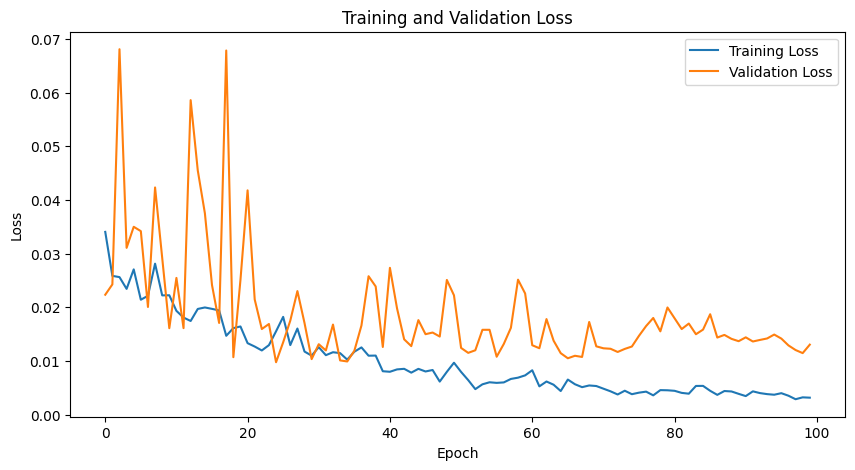

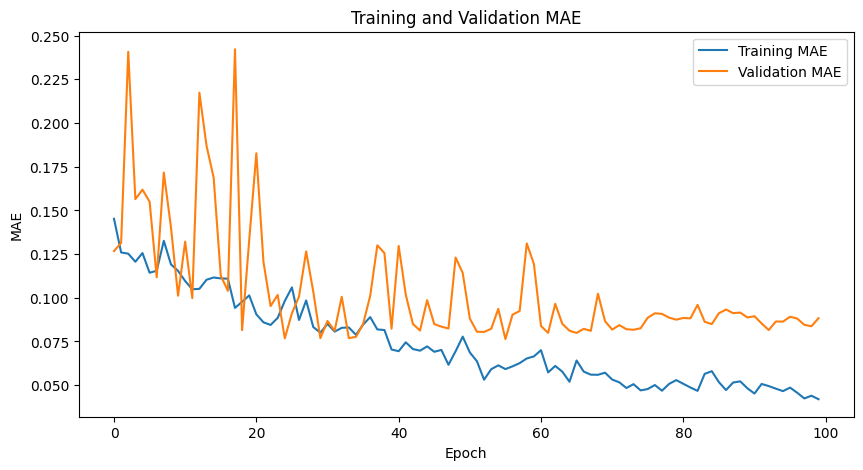

In [71]:
# Tracer la courbe de perte

from matplotlib.pyplot import hist


plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.show()


# Tracer la courbe de MAE (ou autre métrique)

plt.figure(figsize=(10, 5))

plt.plot(history.history['mae'], label='Training MAE')  # Remplacez 'mae' par la métrique que vous avez utilisée

plt.plot(history.history['val_mae'], label='Validation MAE') # Remplacez 'val_mae' par la métrique que vous avez utilisée

plt.title('Training and Validation MAE')

plt.xlabel('Epoch')

plt.ylabel('MAE')

plt.legend()

plt.show()



In [43]:
def predict_humidity(input_data, best_model):
    predictions = best_model.predict(input_data)
    return predictions

In [61]:
y_pred=best_model.predict(X_test)
y_train_pred=best_model.predict(X_train)

def mean_relative_error(y_true, y_pred):

    """Calcule l'erreur relative moyenne."""

    relative_errors = []

    for i in range(len(y_true)):

        if y_true[i] != 0:

            relative_error = np.abs(y_true[i] - y_pred[i]) / np.abs(y_true[i])

            relative_errors.append(relative_error)


    if relative_errors:

        return np.mean(relative_errors) * 100

    else:

        return float('nan')  # Ou une autre valeur pour indiquer que le calcul n'est pas possible


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [62]:
mre=mean_relative_error(y_test, y_pred)
print("Erreur Relative sur les données de test:", mre)
train_mre=mean_relative_error(y_train,y_train_pred)
print("Erreur relativee sur les données d'entraînement:", train_mre)

Erreur Relative sur les données de test: 4.643995897680185
Erreur relativee sur les données d'entraînement: 4.968667504547126


In [ ]:



def model_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    smape = np.mean(np.abs(y_test - y_pred) / ((np.abs(y_test) + np.abs(y_pred)) / 2)) * 100
    medae = median_absolute_error(y_test, y_pred)
    explained_variance = explained_variance_score(y_test, y_pred)
    indicators={'mse':mse,'mae':mae,'r2':r2,'mape':mape,'smape':smape,'medae':medae,'explained_variance':explained_variance}

    # Afficher les résultats
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.4f}%")
    print(f"Median Absolute Error (MedAE): {medae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Explained Variance Score: {explained_variance:.4f}")
    return indicators

In [64]:
model_evaluation(best_model, X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Squared Error (MSE): 0.0622
Mean Absolute Error (MAE): 0.2178
Mean Absolute Percentage Error (MAPE): 12.2028%
Symmetric Mean Absolute Percentage Error (SMAPE): 12.6234%
Median Absolute Error (MedAE): 0.2133
R² Score: 0.7320
Explained Variance Score: 0.9323


{'mse': np.float64(0.062175030346823645),
 'mae': np.float64(0.21779740926546934),
 'r2': 0.7319634425713164,
 'mape': np.float64(12.202810420235837),
 'smape': np.float64(12.623365992443865),
 'medae': np.float64(0.21328020095825195),
 'explained_variance': 0.932288217405874}